In [1]:
import pandas as pd # import the pandas library and alias it as 'pd'

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [12]:
df_test

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English


In [2]:
# Display basic info about the dataframe
print(df_train.info())

# Display the first few rows of the dataframe
print(df_train.head())

# Display descriptive statistics for numerical features
print(df_train.describe())

# Check for missing values in each column
print(df_train.isnull().sum())

# Explore unique values for categorical features
for column in df_train.columns:
  if df_train[column].dtype == 'object':
    print(f"Unique values for {column}: {df_train[column].unique()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB
None
           id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in 

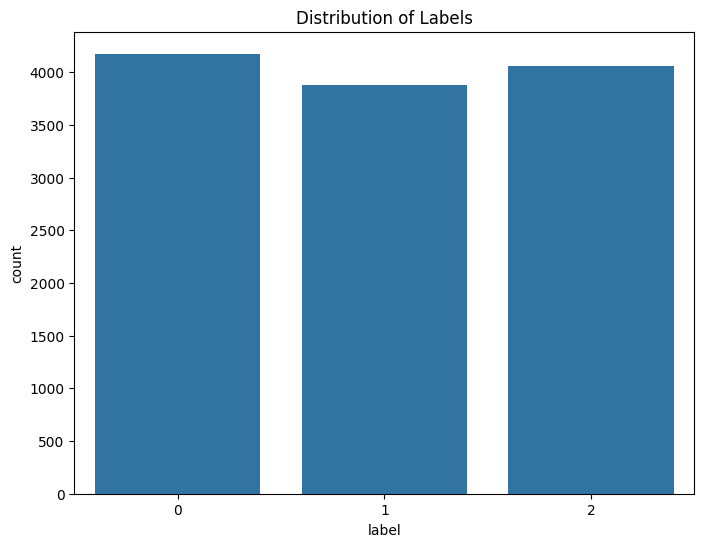

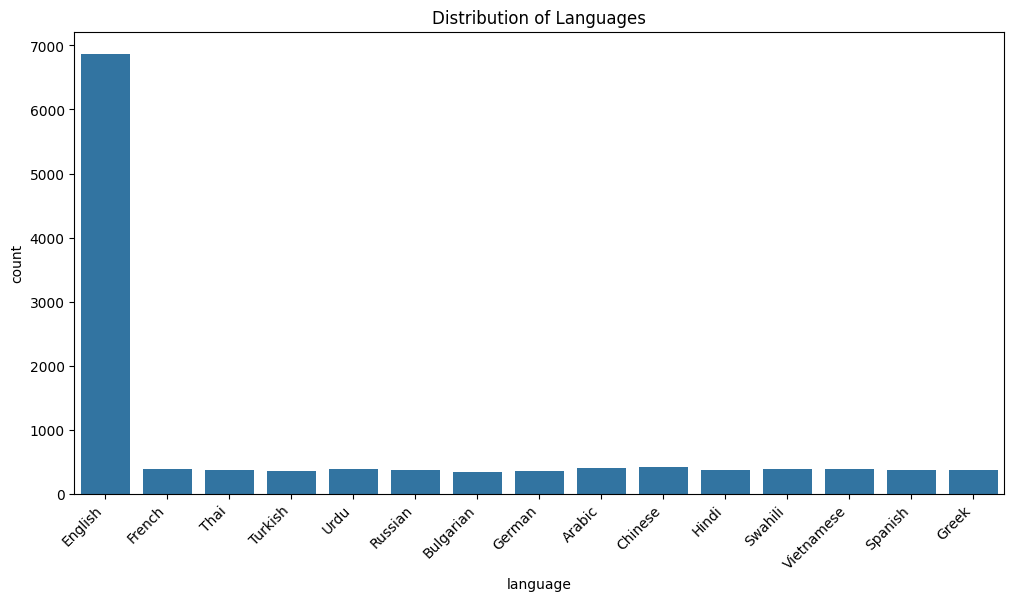

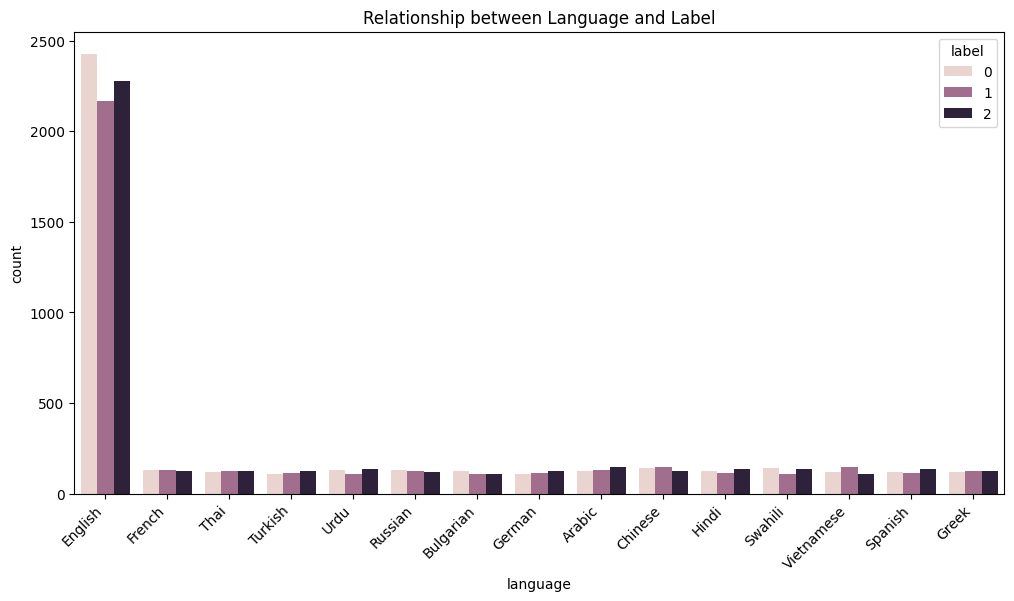

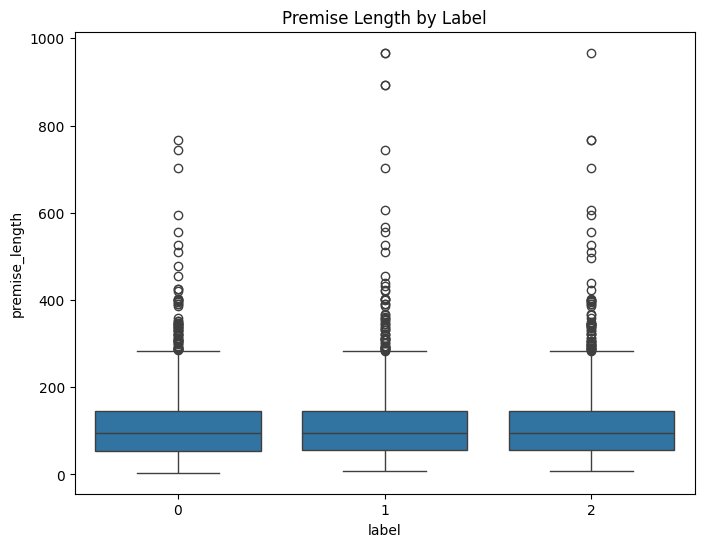

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_train)
plt.title('Distribution of Labels')
plt.show()

# Plot the distribution of languages
plt.figure(figsize=(12, 6))
sns.countplot(x='language', data=df_train)
plt.title('Distribution of Languages')
plt.xticks(rotation=45, ha='right')
plt.show()

# Analyze the relationship between language and label
plt.figure(figsize=(12, 6))
sns.countplot(x='language', hue='label', data=df_train)
plt.title('Relationship between Language and Label')
plt.xticks(rotation=45, ha='right')
plt.show()

# You can explore further by plotting the length of premise and hypothesis against the label
# or by creating word clouds for premise and hypothesis based on label.
# Here's an example of plotting the length of premise:
df_train['premise_length'] = df_train['premise'].apply(len)
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='premise_length', data=df_train)
plt.title('Premise Length by Label')
plt.show()


In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Prepare the data for training
train_encodings = tokenizer(df_train['premise'].tolist(), df_train['hypothesis'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(df_test['premise'].tolist(), df_test['hypothesis'].tolist(), truncation=True, padding=True)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
train_dataset = MyDataset(train_encodings, df_train['label'].tolist())
test_dataset = MyDataset(test_encodings)

In [9]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=200,
    fp16=True
)
# Set the device
if torch.cuda.is_available():
    model.to('cuda')


In [10]:
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Train the model
trainer.train()

# Generate predictions on the test set
predictions = trainer.predict(test_dataset)

# Process predictions (e.g., get predicted labels)
predicted_labels = np.argmax(predictions.predictions, axis=1)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss
200,0.801500
400,0.770800
600,0.905600


In [13]:
# Create a submission DataFrame
submission_df = pd.DataFrame({'id': df_test['id'], 'label': predicted_labels})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)